# Classification of Food-101 datasets

As the name says Food-101 has **101** numbers of classes.
<br>Let's have a quick overview of the dataset: <br>

- _No. of food categories (classes):_ **101** <br>
- _Total no. of images:_ **101,000** (1000 images/class) <br>
- _Training images/class:_ **750** <br>
- _Test images/class:_ **250**<br>
- _Rescaled Image size (maximum):_ **(512x512)** pixels <br>

_**N.B**: The training images were not cleaned i.e. contain some amount of noise (like intense colors or wrong labels)<br>_

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pytorch imports
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace

In [3]:
bs = 64
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

In [4]:
FOOD_PATH = "./food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"
TRAIN_PATH = FOOD_PATH+"/train"
VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'

In [5]:
gpu = True if torch.cuda.is_available() else False
gpu

True

In [6]:
filename = MODEL_PATH+'clr.pth'

### Helper Functions

In [7]:
def pp_(*args, n_dash=120):
    for arg in args:
        print(arg)
        print("-"*n_dash)

In [8]:
def list_dir(path="./"): return os.listdir(path)

In [9]:
def cal_mean_std(train_data):
    return np.mean(train_data, axis=(0,1,2))/255, np.std(train_data, axis=(0,1,2))/255

In [10]:
def save_checkpoint(model, is_best, filename='model_data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
# from fastai library
def load_checkpoint(model, filename = 'model_data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)        

In [11]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))    

In [12]:
def calc_iters(dataset, num_epochs, bs):
    return int(len(dataset) * num_epochs /bs)

In [13]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = output.shape[0]
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

In [14]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

In [15]:
def freeze(model):
    child_counter = 0
    for name, child in model.named_children():
        if child_counter < 7:
            print("name ",name, "child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
            children_of_child_counter = 0
            for children_of_child in child.children():
                if children_of_child_counter < 2:
                    for param in children_of_child.parameters():
                        param.requires_grad = False
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was frozen')
                else:
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
                children_of_child_counter += 1

        else:
            print("name ",name, "child ",child_counter," was not frozen")
        child_counter += 1

In [16]:
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

In [17]:
def print_frozen_state(model):
    child_counter = 0
    for name, child in model.named_children():
        for param in child.parameters():
            if param.requires_grad == True:
                print("child ",child_counter,"named:",name," is unfrezed")
            elif param.requires_grad == False:
                print("child ",child_counter,"named:",name," is frezed")
        child_counter += 1

In [18]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [19]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

## Dataset Preparation

Create a class to download & prepare train and validation data

In [20]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats[0]
        self.imgenet_std = imagenet_stats[1]
   
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return train_tfms, valid_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)        
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes

    
    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()    

Download the data from source and extract

###### Download data

In [21]:
food.get_data_extract()

Dataset already exists


In [22]:
!ls food-101/

README.txt  images  license_agreement.txt  meta  train	valid


In [23]:
pp_(list_dir(FOOD_PATH), list_dir(IMG_PATH), list_dir(META_PATH))

['meta', 'images', '.ipynb_checkpoints', 'train', 'valid', 'license_agreement.txt', 'README.txt']
------------------------------------------------------------------------------------------------------------------------
['gnocchi', 'cheese_plate', 'ramen', 'ice_cream', 'donuts', 'cup_cakes', 'french_onion_soup', 'bruschetta', 'poutine', 'grilled_cheese_sandwich', 'grilled_salmon', 'chicken_curry', 'baby_back_ribs', 'crab_cakes', 'caprese_salad', 'strawberry_shortcake', 'garlic_bread', 'tuna_tartare', 'hummus', 'chocolate_mousse', 'tiramisu', 'huevos_rancheros', 'french_toast', 'samosa', 'peking_duck', 'beet_salad', 'spring_rolls', 'pizza', 'macarons', 'fish_and_chips', 'beignets', 'panna_cotta', 'beef_carpaccio', 'red_velvet_cake', 'foie_gras', 'clam_chowder', 'pulled_pork_sandwich', 'hamburger', 'lobster_bisque', 'spaghetti_bolognese', 'frozen_yogurt', 'macaroni_and_cheese', 'omelette', 'caesar_salad', 'croque_madame', 'chocolate_cake', 'pho', 'nachos', 'falafel', 'fried_calamari', 'ch

**meta** folder contains the text files - train.txt and test.txt <br>
**train.txt** contains the list of images that belong to training set <br>
**test.txt** contains the list of images that belong to test set <br>
**classes.txt** contains the list of all classes of food <br>

In [24]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [25]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


###### Split the image data into train and test using train.txt and test.txt

In [26]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [27]:
# # Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
# print("Creating train data...")
# prepare_data(META_PATH+'train.txt', IMG_PATH, TRAIN_PATH)

In [28]:
# # Prepare validation data by copying images from food-101/images to food-101/valid using the file test.txt
# print("Creating validation data...")
# prepare_data(META_PATH+'test.txt', IMG_PATH, VALID_PATH)

In [29]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [30]:
# Check how many files are in the test folder
print("Total number of samples in validation folder")
!find food-101/valid -type d -or -type f -printf '.' | wc -c

Total number of samples in validation folder
25250


###### Create Datasets & DataLoaders

In [31]:
train_ds, valid_ds, classes =  food.get_dataset()
num_classes = len(classes)
pp_(classes,num_classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [32]:
train_dl, valid_dl = food.get_dls(train_ds, valid_ds, bs=bs, num_workers=2)

Wrap all inside databunch

In [33]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"

In [34]:
data = DataBunch(train_dl, valid_dl, c=num_classes)

In [35]:
pp_(data.valid_ds, data.c, data.train_ds)

Dataset ImageFolder
    Number of datapoints: 25250
    Root location: ./food-101/valid
------------------------------------------------------------------------------------------------------------------------
101
------------------------------------------------------------------------------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 75750
    Root location: ./food-101/train
------------------------------------------------------------------------------------------------------------------------


In [36]:
# a = None
# f"Showing one random image from each {'Validation' if a else 'Train'} classes"

###### Visualize random image from each of the 101 classes

In [37]:
# This can be used to print predictions too
def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    imgenet_mean = imagenet_stats[0]
    imgenet_std = imagenet_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

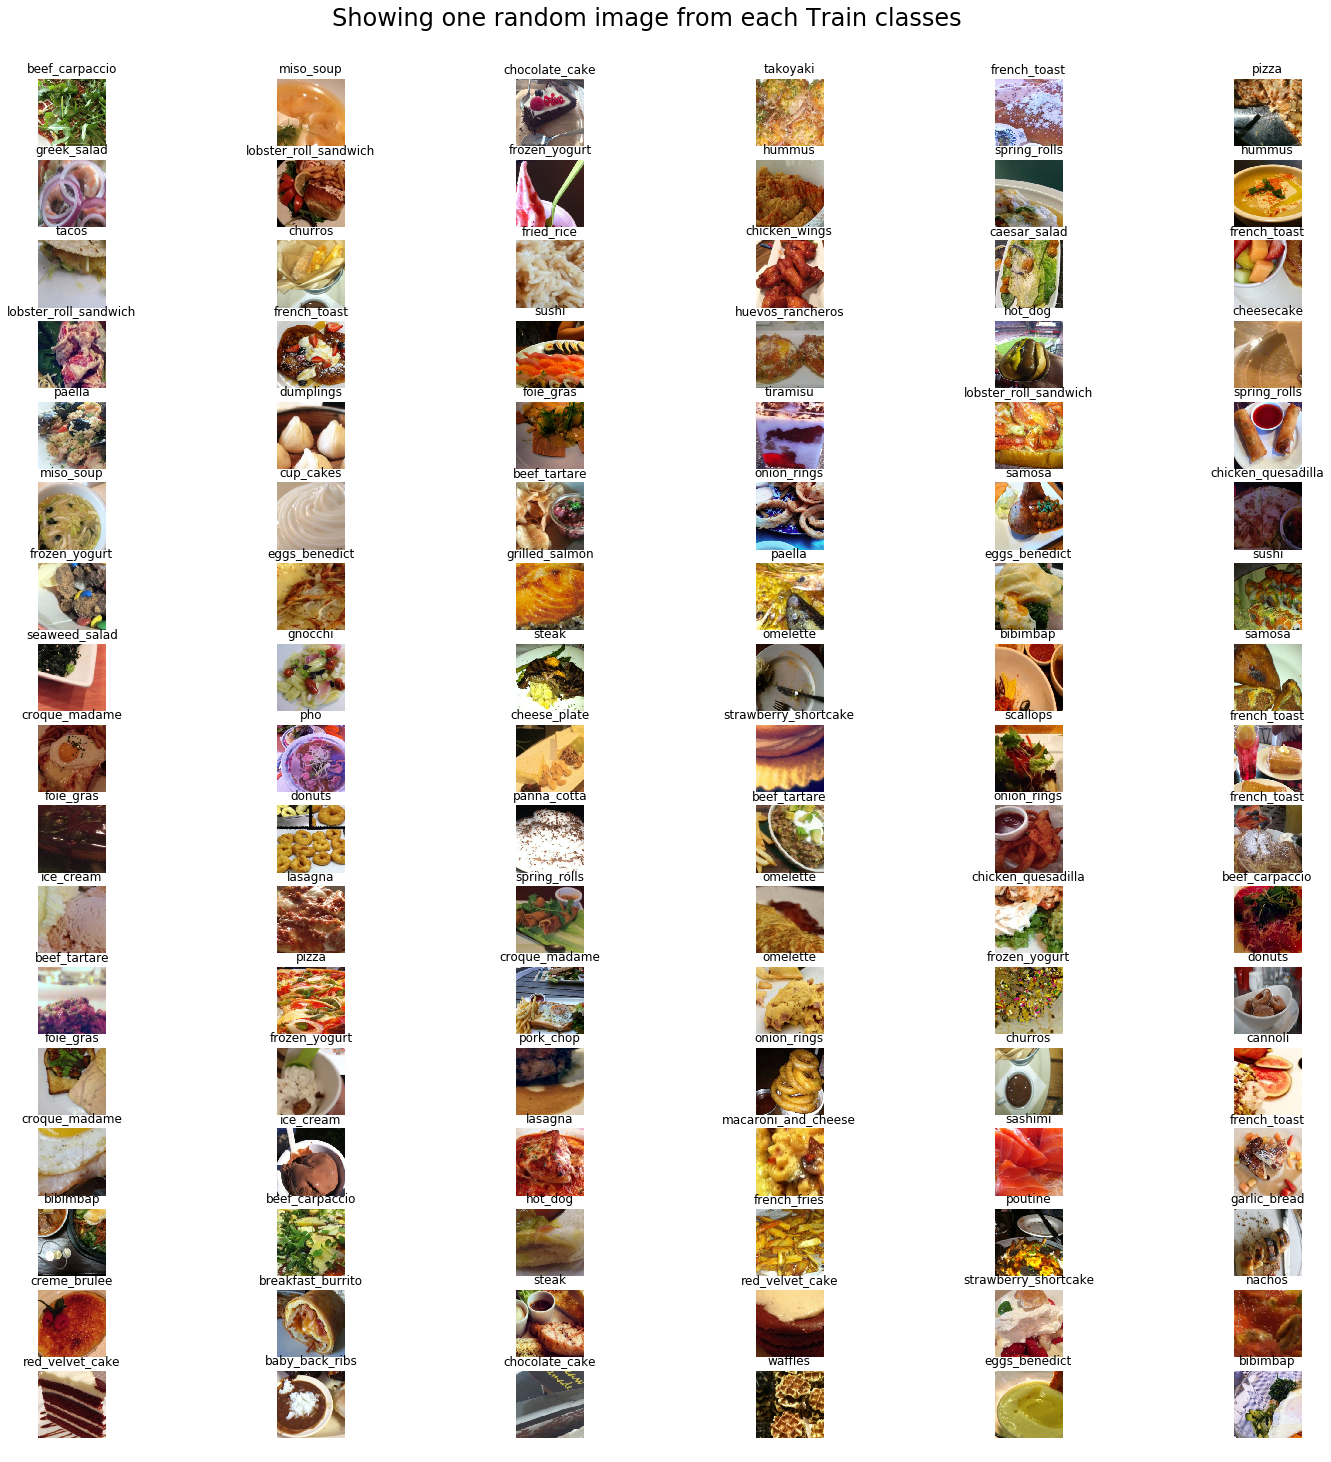

In [38]:
show_ds(data.train_ds, classes)

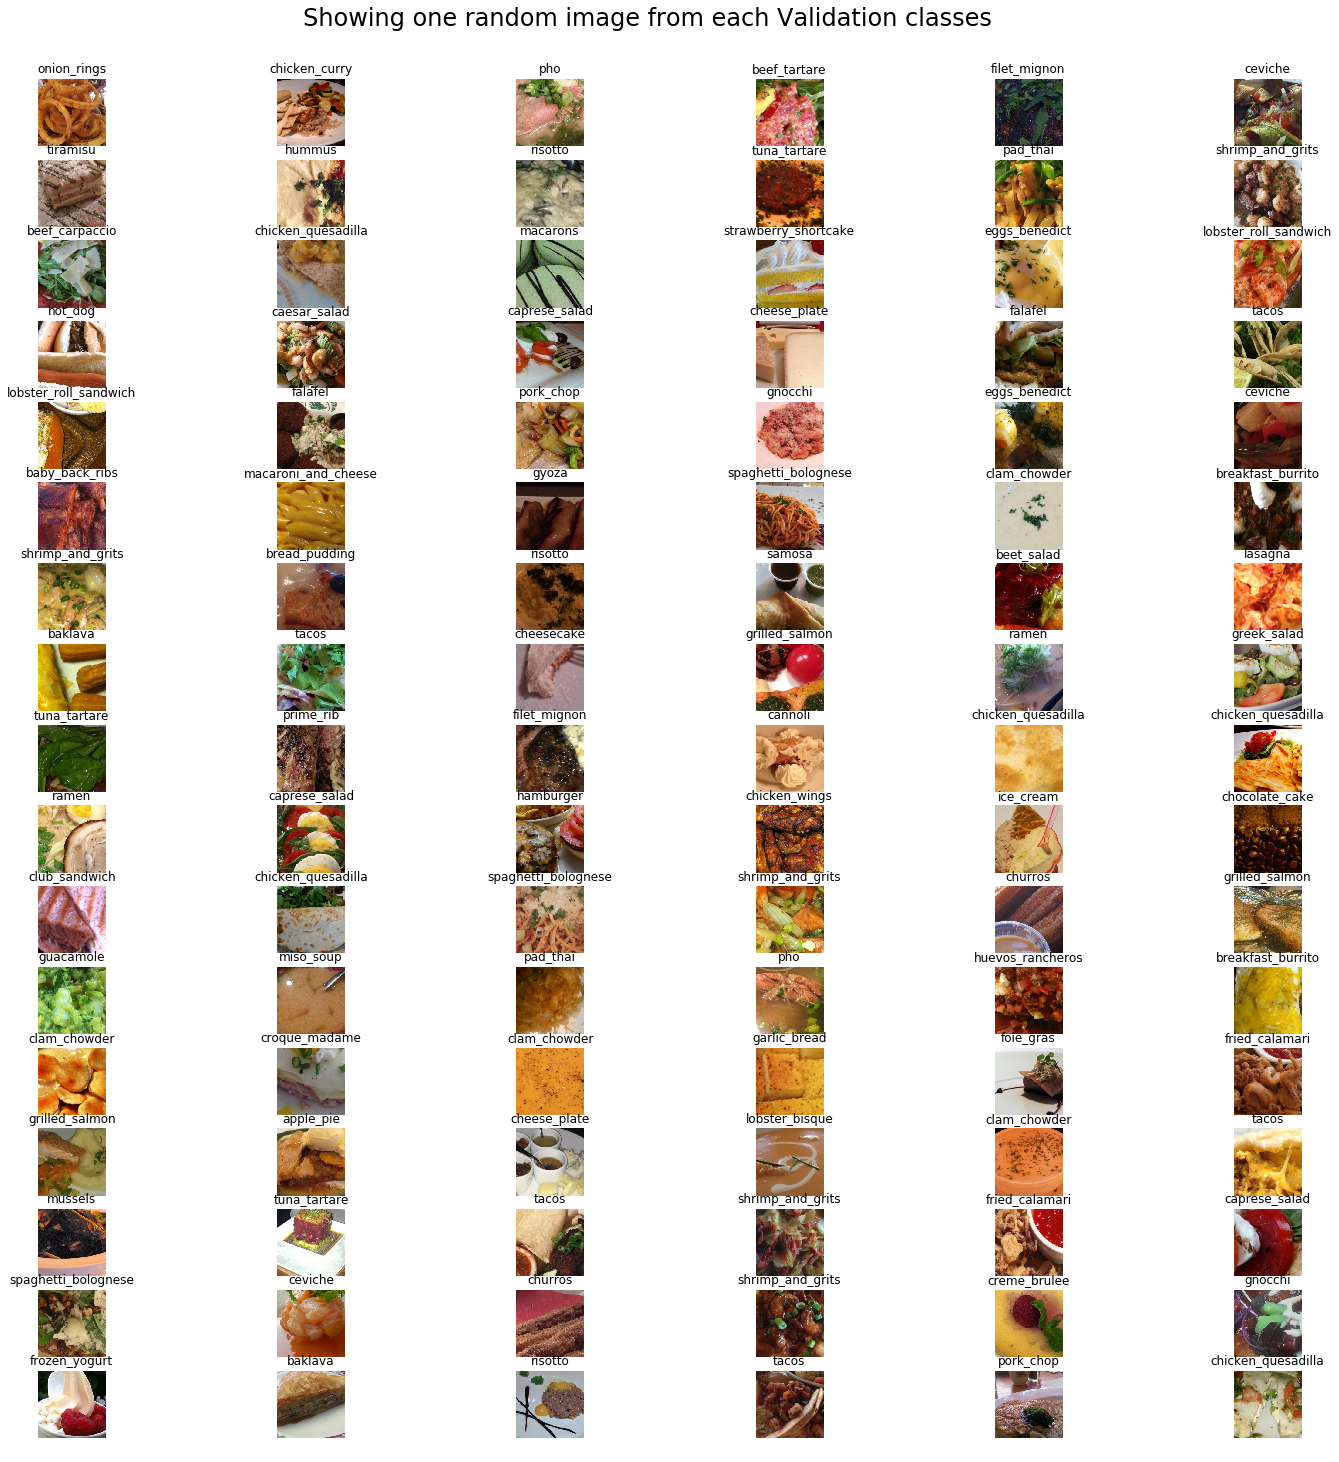

In [39]:
show_ds(data.valid_ds, classes, is_valid=True)

## Training

#### Define Model, Optimizer and Loss Function

We will be using **resnet-50** (SOTA is a resnet50 model), <br> **SGD** optimizer, <br> & **CrossEntropy Loss**

In [40]:
loss_func=nn.CrossEntropyLoss()

In [41]:
def get_model(lr=3e-3,num_classes=num_classes, opt="SGD", **kwargs):
    model_imgnet = models.resnet50(pretrained=True) # model
    num_ftrs = model_imgnet.fc.in_features
    model_imgnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model = model_imgnet.to(device)
#     print(model)
    if opt=="SGD":
        return model, optim.SGD(model.parameters(), lr=lr, **kwargs)
    elif opt=="Adam":
        return model, optim.Adam(model.parameters(), lr=lr, **kwargs)
    else:
        return model, optim.RMSprop(model.parameters(), lr=lr, **kwargs)

In [42]:
class Learner():
    """
    stores Model, Optimizer, Loss Function and Datasets (train & valid)
    """
    def __init__(self, model, opt, loss_func, data ):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

In [43]:
learn = Learner(*get_model(momentum=0.9, weight_decay=1e-4, nesterov=True), loss_func, data)

In [44]:
learn.loss_func = nn.CrossEntropyLoss()
learn.opt = torch.optim.SGD(learn.model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)

In [45]:
pp_(learn.data, learn.loss_func, learn.opt) #, learn.model)

DataBunch obj (train & valid DataLoaders)
------------------------------------------------------------------------------------------------------------------------
CrossEntropyLoss()
------------------------------------------------------------------------------------------------------------------------
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.95
    nesterov: False
    weight_decay: 0.0001
)
------------------------------------------------------------------------------------------------------------------------


Freezing the model (except some last layers)

## The approach is :
- first find the optimal Learnng rate for the freezed model using **LR finder** (cyclical learning rates) plot. Train the **freezed pretrained model** (e.g. resnet-50) for a few epochs with **learning_rate= optimal L.R. (from lr finder)** using **1-cycle-policy**. 
<br><br>
- next, **unfreeze the model** and find optimal learning rate using **LR finder** (cyclical learning rates) plot. <br><br>
- finally train the **unfreezed model** using the **optimal L.R.** (found from L.R. finder) using **1-cycle-policy** for some more epochs <br>

Freeze all layers except last 4 layers:

In [46]:
freeze(learn.model)

name  conv1 child  0  was frozen
name  bn1 child  1  was frozen
name  relu child  2  was frozen
name  maxpool child  3  was frozen
name  layer1 child  4  was frozen
name  layer2 child  5  was frozen
name  layer3 child  6  was frozen
name  layer4 child  0 of child 7  was frozen
name  layer4 child  1 of child 7  was frozen
name  layer4 child  2 of child 7  was not frozen
name  avgpool child  8  was not frozen
name  fc child  9  was not frozen


### One Cycle Policy

In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during whole run with 2 steps of equal length. During first step, increase the learning rate from lower learning rate to higher learning rate. And in second step, decrease it from higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one addition to this. - During last few hundred/thousand iterations of cycle reduce the learning rate to 1/100th or 1/1000th of the lower learning rate.

Also, Author suggests that reducing momentum when learning rate is increasing. So, we make one cycle of momentum also with learning rate - Decrease momentum when learning rate is increasing and increase momentum when learning rate is decreasing.

In [62]:
# %load OneCycle.py
class OneCycle(object):
    """
    In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during 
    whole run with 2 steps of equal length. During first step, increase the learning rate 
    from lower learning rate to higher learning rate. And in second step, decrease it from 
    higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one 
    addition to this. - During last few hundred/thousand iterations of cycle reduce the 
    learning rate to 1/100th or 1/1000th of the lower learning rate.

    Also, Author suggests that reducing momentum when learning rate is increasing. So, we make 
    one cycle of momentum also with learning rate - Decrease momentum when learning rate is 
    increasing and increase momentum when learning rate is decreasing.

    Args:
        nb              Total number of iterations including all epochs

        max_lr          The optimum learning rate. This learning rate will be used as highest 
                        learning rate. The learning rate will fluctuate between max_lr to
                        max_lr/div and then (max_lr/div)/div.

        momentum_vals   The maximum and minimum momentum values between which momentum will
                        fluctuate during cycle.
                        Default values are (0.95, 0.85)

        prcnt           The percentage of cycle length for which we annihilate learning rate
                        way below the lower learnig rate.
                        The default value is 10

        div             The division factor used to get lower boundary of learning rate. This
                        will be used with max_lr value to decide lower learning rate boundary.
                        This value is also used to decide how much we annihilate the learning 
                        rate below lower learning rate.
                        The default value is 10.
    """
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        
    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    
    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom


In [63]:
bs

64

In [64]:
# learn.opt = torch.optim.SGD(learn.model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-4)

In [65]:
# load_checkpoint(learn.model, filename)

#### Train for a few epochs(3 to 5) using CLR and 1-cycle-policy

In [66]:
total = 0
correct = 0

train_loss = 0
test_loss = 0
best_acc = 0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

preds =[]

In [67]:
train_stats = AvgStats()
test_stats = AvgStats()

In [68]:
def train(epoch=0, use_cycle = False, model=learn.model):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
    t1 = tqdm(learn.data.train_dl, leave=False, total=int(len(learn.data.train_dl)))
        
    for i, (input, target) in enumerate(t1):
        bt_start = time.time()
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
                
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(learn.opt, lr)
            update_mom(learn.opt, mom)
            
        output = model(var_ip)
        loss = learn.loss_func(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()

In [69]:
def validate(model=learn.model):
    avg_beta = 0.98
    model.eval()
    global val_accs, val_losses
    running_loss = 0.
    t2 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.valid_dl)))
    with torch.no_grad():
        for i, (input, target) in enumerate(t2):
            bt_start = time.time()
            if gpu :
                input, target = input.cuda(), target.cuda() 
            else :
                input, target = input.cpu(), target.cpu()
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = learn.loss_func(output, var_tg)

            running_loss = avg_beta * running_loss + (1-avg_beta) *loss
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss, prec, time.time()-bt_start)

            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [70]:
def fit(epochs, use_onecycle=False, model=learn.model):
    print(f"{'epoch':5s}{'train_loss':>15s}{'valid_loss':>15s}{'train_acc':>15s}{'valid_acc':>15s}")
    for epoch in tqdm(range(epochs), leave=False):
        train(epoch, use_onecycle, model)
        validate(model)
        print(f"{epoch+1:5}{trn_losses[-1]:15.5f}{val_losses[-1]:15.5f}{trn_accs[-1]:15.5f}{val_accs[-1]:15.5f}")
#         print("{}\t{:06.5f}\t{:06.5f}\t{:06.5f}\t{:06.5f}"
#               .format(epoch+1, trn_losses[-1], val_losses[-1], trn_accs[-1], val_accs[-1]))

### Cyclic Learning Rates
We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.<br>
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.<br>
We'll plot loss vs learning rate plot.<br>
We'll then select learning rate that is one power higher than the one where loss is minimum <br>
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate <br>
can be set to 1/3, 1/4th of max value.

reference: https://github.com/nachiket273/One_Cycle_Policy

In [71]:
# %load CLR.py
import math
import matplotlib.pyplot as plt


class CLR(object):
    """
    The method is described in paper : https://arxiv.org/abs/1506.01186 to find out optimum 
    learning rate. The learning rate is increased from lower value to higher per iteration 
    for some iterations till loss starts exploding.The learning rate one power lower than 
    the one where loss is minimum is chosen as optimum learning rate for training.

    Args:
        optim   Optimizer used in training.

        bn      Total number of iterations used for this test run.
                The learning rate increasing factor is calculated based on this 
                iteration number.

        base_lr The lower boundary for learning rate which will be used as
                initial learning rate during test run. It is adviced to start from
                small learning rate value like 1e-4.
                Default value is 1e-5

        max_lr  The upper boundary for learning rate. This value defines amplitude
                for learning rate increase(max_lr-base_lr). max_lr value may not be 
                reached in test run as loss may explode before reaching max_lr.
                It is adviced to use higher value like 10, 100.
                Default value is 100.

    """
    def __init__(self, learn, base_lr=1e-5, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = learn.opt
        self.bn = len(learn.data.train_dl) - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')


In [72]:
def find_LR(clr):
    t = tqdm(learn.data.train_dl, leave=False, total=len(learn.data.train_dl))
    running_loss = 0.
    avg_beta = 0.98
    learn.model.train()
    for i, (input, target) in enumerate(t):
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
        output = learn.model(var_ip)
        loss = learn.loss_func(output, var_tg)

        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)

        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(learn.opt, lr)   

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()

       # print('Iteration: [{0}/{1}]  '
            # 'Loss: {2}  '.format(i, len(train_loader), smoothed_loss))

###### 1st LR find and train for few epochs
(Skip if doing for 2nd time i.e. resuming the work)

In [73]:
clr1 = CLR(learn)

In [57]:
find_LR(clr1)

In [58]:
save_model(learn.model, MODEL_PATH+"clr1.pth")

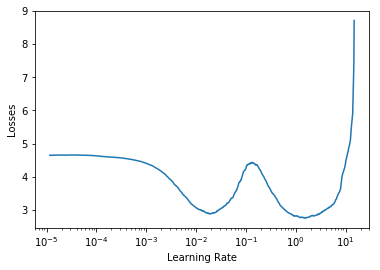

In [59]:
clr1.plot()

From the LR finder plot, we will use learning rate = **2e-1**

In [61]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-1, momentum_vals=(0.95, 0.8), prcnt=10)
fit(3, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        3.32778        3.03631       11.00000       14.00000


    2        2.55911        2.29414       22.00000       24.00000


    3        2.18152        2.17037       29.00000       30.00000


In [62]:
save_model(learn.model, MODEL_PATH+'stage1_3.pth')

In [64]:
fit(3, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        2.22595        2.16083       33.00000       34.00000


    2        2.06325        2.05883       36.00000       37.00000


    3        1.80978        1.80483       39.00000       39.00000


In [65]:
save_model(learn.model, MODEL_PATH+'stage1_6.pth')

**returning to work**

In [75]:
load_model(learn.model, MODEL_PATH+'stage1_6.pth')

In [76]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-1, momentum_vals=(0.95, 0.8), prcnt=10)
fit(2, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        1.91751        1.65206       52.00000       52.00000


    2        1.86806        1.79075       52.00000       52.00000


In [77]:
save_model(learn.model, MODEL_PATH+'stage1_8.pth')

In [67]:
# print_frozen_state(learn.model)

###### Refactoring

In [66]:
# class One_Cycle():
#     """
#       In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during 
#       whole run with 2 steps of equal length. During first step, increase the learning rate 
#       from lower learning rate to higher learning rate. And in second step, decrease it from 
#       higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one 
#       addition to this. - During last few hundred/thousand iterations of cycle reduce the 
#       learning rate to 1/100th or 1/1000th of the lower learning rate.
#       Also, Author suggests that reducing momentum when learning rate is increasing. So, we make 
#       one cycle of momentum also with learning rate - Decrease momentum when learning rate is 
#       increasing and increase momentum when learning rate is decreasing.
#       Args:
#           num_iters       Total number of iterations including all epochs
#           max_lr          The optimum learning rate. This learning rate will be used as highest 
#                           learning rate. The learning rate will fluctuate between max_lr to
#                           max_lr/div and then (max_lr/div)/div.
#           momentum_vals   The maximum and minimum momentum values between which momentum will
#                           fluctuate during cycle.
#                           Default values are (0.95, 0.85)
#           prcnt           The percentage of cycle length for which we annihilate learning rate
#                           way below the lower learnig rate.
#                           The default value is 10
#           div             The division factor used to get lower boundary of learning rate. This
#                           will be used with max_lr value to decide lower learning rate boundary.
#                           This value is also used to decide how much we annihilate the learning 
#                           rate below lower learning rate.
#                           The default value is 10.
#       """

#     def __init__(self,num_iters, max_lr, mom_vals=(0.95, 0.85), prcnt=10, div=10):
#         self.num_iters, self.high_lr, self.low_mom, self.high_mom, self.prcnt, self.div, self.iters, self.lrs, self.moms\
#         = num_iters, max_lr, mom_vals[0], mom_vals[1], prcnt, div, 0, [], []

#         self.step_len = int(self.num_iters * (1- self.prcnt/100)/2)
    
#     def __call__(self):
#         self.iters += 1
#         lr = self._calc_lr()
#         mom = self._calc_mom()
#         return lr, mom
    
#     def _calc_lr(self):
#         if self.iters==self.num_iters:
#             self.iters=0
#             self.lrs.append(self.high_lr/self.div)
#         return self.high_lr/self.div
        
#         if self.iters > 2*self.step_len:
#             ratio = (self.iters - 2*self.step_len) / (self.num_iters - 2*self.step_len)
#             lr = self.high_lr * (1- 0.99*ratio)/self.div
# #             lr = (self.high_lr/self.div) * (1-ratio*(1-(1/self.div))
        
#         elif self.iters > self.step_len:
#             ratio = 1 - (self.iters - self.step_len) / self.step_len
#             lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
            
#         else:
#             ratio = self.iters/self.step_len
#             lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div      
        
#         self.lrs.append(lr)
#         return lr
            
    
#     def _calc_mom(self):
#         if self.iters==self.num_iters:
#             self.iters = 0
#             self.moms.append(self.high_mom)
#         return self.high_mom
        
#         if self.iters > 2*self.step_len:
#             mom = self.high_mom
        
#         elif self.iters > self.step_len:
#             ratio = (self.iters - self.step_len)/self.step_len
#             mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
#         else:
#             ratio = self.iters/self.step_len
#             mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        
#         self.moms.append(mom)
#         return mom

In [71]:
# class fit_one_cycle():
#     def __init__(self,epochs, learn, one_cycle_schedule):
#         self.epochs, self.learn = epochs, learn
#         self.avg_beta = 0.98
#         self.total, self.correct, self.train_loss, self.test_loss, self.best_acc = 0, 0, 0, 0, 0
#         self.trn_losses, self.trn_accs, self.val_losses, self.val_accs, self.preds = [], [], [], [], []
#         self.train_stats, self.valid_stats = AvgStats(), AvgStats()
        
#         self.data, self.model, self.optim, self.loss_func = learn.data, learn.model, learn.opt, learn.loss_func
        
#         self.onecycle = one_cycle_schedule
        
    
#     def update_lr_mom(self, lr=None, mom=None, is_mom=False):
#         optim = self.optim
#         if not is_mom:
#             for g in optim.param_groups:
#                 g['lr'] = lr
#         if is_mom:
#             for g in optim.param_groups:
#                 g['momentum'] = mom 
    
#     def accuracy(self,output, target, is_test=False):
#         batch_size = target.size(0)
#         self.total += batch_size

#         _, pred = torch.max(output, 1)
#         if is_test:
#             self.preds.extend(pred)
#         self.correct += (pred == target).sum()
#         return 100 * self.correct / self.total                
                
#     def train(self, use_cycle = True):
#         self.model.train()
#         is_improving = True
#         counter = 0
#         running_loss = 0.
#         t1 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.train_dl)))
#         for i, (xb, yb) in enumerate(t1):
#             bt_start = time.time()
#             xb, yb = xb.to(device), yb.to(device)

#             if use_cycle:    
#                 lr, mom = self.onecycle()
#                 self.update_lr_mom(lr=lr)
#                 self.update_lr_mom(mom=mom, is_mom=True)

#             output = self.learn.model(xb)
#             loss = self.learn.loss_func(output, yb)

#             running_loss = self.avg_beta * running_loss + (1-self.avg_beta) *loss
#             smoothed_loss = running_loss / (1 - self.avg_beta**(i+1))

#             self.trn_losses.append(smoothed_loss)

#             # measure accuracy and record loss
#             prec = self.accuracy(output, yb)
#             self.trn_accs.append(prec)

#             self.train_stats.append(smoothed_loss, prec, time.time()-bt_start)
#             if prec > self.best_acc :
#                 self.best_acc = prec
#                 save_checkpoint(self.model, True)

#             # compute gradient and do SGD step
#             self.optim.zero_grad()
#             loss.backward()
#             self.optim.step()
            
            
#     def validate(self):
#         running_loss = 0.
#         self.model.eval()
#         t2 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.valid_dl)))
#         with torch.no_grad():
#             for i, (xb, yb) in enumerate(t2):
#                 bt_start = time.time()
#                 xb, yb = xb.to(device), yb.to(device)
#                 output = self.model(xb)
#                 loss = self.loss_func(output, yb)

#                 running_loss = self.avg_beta * running_loss + (1-self.avg_beta) *loss
#                 smoothed_loss = running_loss / (1 - self.avg_beta**(i+1))

#                 # measure accuracy and record loss
#                 prec = self.accuracy(output, yb, is_test=True)
#                 self.valid_stats.append(loss, prec, time.time()-bt_start)

#                 self.val_losses.append(smoothed_loss)
#                 self.val_accs.append(prec)
            
#     def fit(self, use_onecycle=True):
#         print("Epoch\tTrn_loss\tVal_loss\tTrn_acc\t\tVal_acc")
#         for epoch in tqdm(range(self.epochs)):
#             self.train(use_onecycle)
#             self.validate()
#             print("{}\t{:06.8f}\t{:06.8f}\t{:06.8f}\t{:06.8f}"
#                   .format(epoch+1, self.trn_losses[-1], self.val_losses[-1], self.trn_accs[-1], self.val_accs[-1]))

In [72]:
# onecycle = One_Cycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=6e-4, mom_vals=(0.95, 0.8), prcnt=10)
# fit_one_cycle(epochs,learn, onecycle).fit()

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


1	4.90365553	4.25717688	0.00000000	0.00000000


2	4.87953520	4.23536205	0.00000000	0.00000000


3	4.87030935	4.22634315	0.00000000	0.00000000


In [73]:
# save_checkpoint(learn.model, True, filename=MODEL_PATH+'stage-1.pth')

In [55]:
# data = DataBunch(*food.get_dls(train_ds, valid_ds, bs=bs//2, num_workers=2), c=num_classes)

# learn = Learner(*get_model(momentum=0.9, weight_decay=1e-4, nesterov=True), loss_func, data)

In [59]:
# load_checkpoint(learn.model,'model_data/stage1_3.pth' )

In [60]:
learn.data.train_dl.batch_size

64

## Unfreeze & train for longer epochs
(Works can be resumed from here)

Now we will unfreeze the model and again find the optimal lr using **Cyclic Learning Rates** 

In [78]:
load_model(learn.model, MODEL_PATH+'stage1_8.pth')

In [79]:
unfreeze(learn.model)

In [81]:
# print_frozen_state(learn.model)

###### 2nd LR Find: (Skip when doing for 2nd time)

In [75]:
clr2 = CLR(learn)
find_LR(clr2)

In [76]:
save_model(learn.model, MODEL_PATH+"clr2.pth")

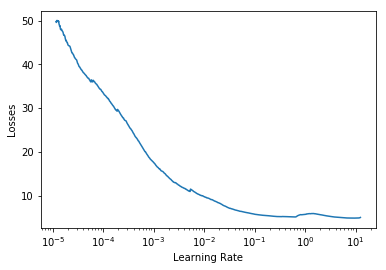

In [84]:
clr.plot()

From the LR finder plot, we will use learning rate = **3e-4**

Train the entire model for a few more epochs with the optimal max_lr found above (3e-4)

In [85]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=3e-4, momentum_vals=(0.95, 0.8), prcnt=10)
fit(10, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1      175.66809      145.19600       35.00000       34.00000


    2       79.13637       60.90794       31.00000       30.00000


    3       64.78852       35.89868       27.00000       26.00000


    4       38.83132       25.72659       24.00000       24.00000


    5       34.04134        7.59983       22.00000       22.00000


    6       24.06625       12.17246       20.00000       20.00000


    7       23.04848        6.28054       19.00000       18.00000


    8       22.67738       23.80483       18.00000       17.00000


    9       20.77325        8.80528       16.00000       16.00000


   10       16.19079       17.35918       15.00000       15.00000


In [86]:
save_model(learn.model, MODEL_PATH+"stage2_10-test.pth")

##### Train with 1e-3
seems lr = 3e-4 not working well, we will go with **1e-3**

In [ ]:
load_model(learn.model, MODEL_PATH+'stage1_8.pth')
unfreeze(learn.model)

In [80]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=1e-3, momentum_vals=(0.95, 0.8), prcnt=10)
fit(10, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        1.44252        1.35666       54.00000       55.00000


    2        1.33010        1.21230       57.00000       58.00000


    3        1.22469        1.11375       59.00000       60.00000


    4        1.19387        1.12470       61.00000       61.00000


    5        1.16795        1.06768       62.00000       62.00000


    6        1.09794        1.01795       63.00000       63.00000


    7        1.08425        1.01993       64.00000       64.00000


    8        0.99959        0.98134       65.00000       65.00000


    9        0.98002        0.95105       66.00000       66.00000


   10        1.01650        0.96451       66.00000       67.00000


In [82]:
save_model(learn.model, MODEL_PATH+"stage2_10.pth")

Train some more epochs

In [83]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=1e-3, momentum_vals=(0.95, 0.8), prcnt=10)
fit(10, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        0.97069        0.95972       67.00000       67.00000


    2        0.91651        0.91505       68.00000       68.00000


    3        0.89518        0.88560       68.00000       68.00000


    4        0.87758        0.90952       69.00000       69.00000


    5        0.84775        0.86667       69.00000       69.00000


    6        0.80452        0.83865       70.00000       70.00000


    7        0.82181        0.88673       70.00000       70.00000


    8        0.80760        0.85720       70.00000       70.00000


    9        0.75609        0.82961       71.00000       71.00000


   10        0.78880        0.87892       71.00000       71.00000


In [85]:
save_model(learn.model, MODEL_PATH+"stage2_20.pth")

In [86]:
# load_model(learn.model, MODEL_PATH+"stage2_20.pth")

In [87]:
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=3e-3, momentum_vals=(0.95, 0.8), prcnt=10)
fit(15, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        0.96254        1.05596       71.00000       71.00000


    2        0.92924        1.02465       71.00000       71.00000


    3        0.73393        0.81104       72.00000       72.00000


    4        0.81123        0.96367       72.00000       72.00000


    5        0.79675        0.90319       72.00000       72.00000


    6        0.67074        0.78392       72.00000       72.00000


    7        0.73537        0.90366       73.00000       73.00000


    8        0.75053        0.91028       73.00000       73.00000


    9        0.60967        0.78067       73.00000       73.00000


   10        0.69682        0.88744       73.00000       73.00000


   11        0.69493        0.93262       73.00000       73.00000


   12        0.56736        0.77443       74.00000       74.00000


   13        0.66802        0.93466       74.00000       74.00000


   14        0.62458        0.82233       74.00000       74.00000


   15        0.52437        0.75300       74.00000       74.00000


In [88]:
save_model(learn.model, MODEL_PATH+"stage2_35.pth")

In [86]:
# load_model(learn.model, MODEL_PATH+"stage2_35.pth")

We are getting a descent model having % valdation accuracy

#### Visualizations
some visualizations for our experiment

In [157]:
plt.rcParams['figure.figsize'] = (5, 4)

1. Accuracy vs Iterations:

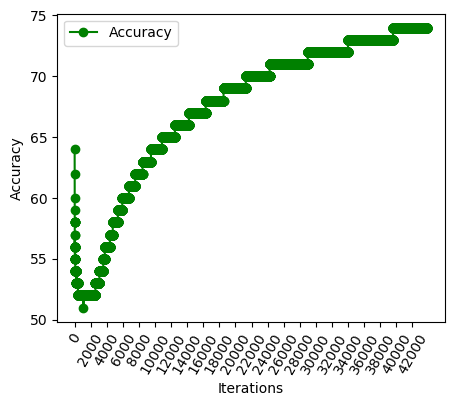

In [158]:
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=5))
plt.plot(train_stats.precs, 'go-', label='Accuracy')
plt.legend()
plt.xticks(np.arange(0, len(train_stats.precs), step=2000), rotation=60)
plt.savefig('onecycle_acc.jpg')

2. Epochs vs Loss:

In [134]:
ep_losses = []
for i in range(0, len(train_stats.losses), len(learn.data.train_dl)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(learn.data.valid_dl)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

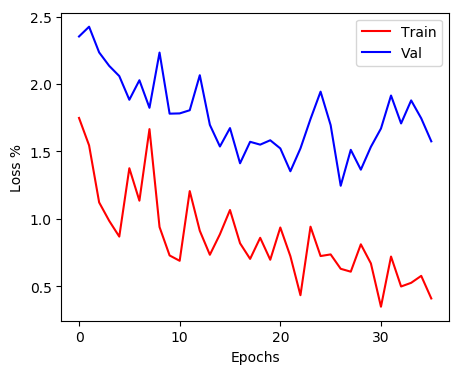

In [159]:
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 1000, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss.jpg')

3. Iterations vs Learning Rate:

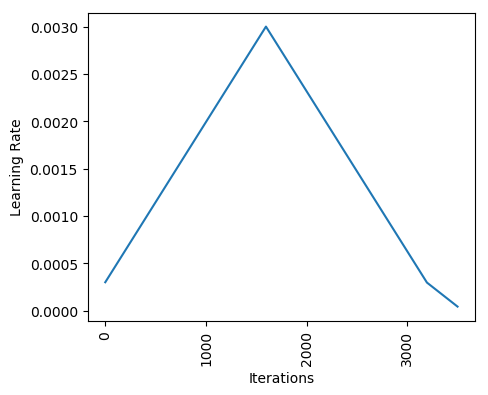

In [160]:
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs[:3500])
plt.savefig('onecycle_lr.jpg')

4. Iterations vs Momentum:

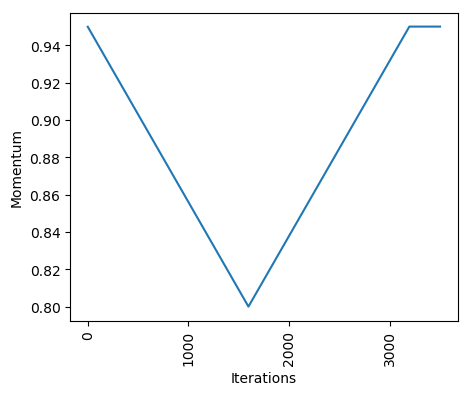

In [161]:
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms[:3500])
plt.savefig('onecycle_mom.jpg')